In [1]:
%matplotlib inline

In [2]:
import hcipy as hci
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.origin'] = True

## **Parameters**

In [4]:
wvlgth = 1e-6 #666e-9  

diam_aperture = 1.2           
focal_length = 18*diam_aperture 

diam_obs = 0.3/diam_aperture                                 # obscuration ratio
nb_spid = 4                                                  # [m]
spid_width = 0.05                                            # [m]

print('Wavelength = {} m'.format(wvlgth))
print('Aperture = {} m'.format(diam_aperture))
print('Focal length = {x:.3f} m \n'.format(x=focal_length))
print('Fresnel number = {x:.3f}'.format(x=diam_aperture**2/(wvlgth*focal_length)))

Wavelength = 1e-06 m
Aperture = 1.2 m
Focal length = 21.600 m 

Fresnel number = 66666.667


In [5]:
grid_size_pix = 1024
grid_diam = 1.5*diam_aperture

In [6]:
pupil_grid = hci.make_pupil_grid(grid_size_pix, grid_diam)  #It's a computational grid, nothing physical
print('On pupil plane, there is {} m/pix'.format(pupil_grid.delta))  #same as grid_diam/grid_size_pix
print('This is not a real pixel ! This is for the computation\'s sake')

On pupil plane, there is [0.00175953 0.00175953] m/pix
This is not a real pixel ! This is for the computation's sake


## **Aperture Auxtel (spiders + central obscuration)**

In [7]:
central_obs = hci.aperture.make_obstructed_circular_aperture(diam_aperture, diam_obs)
spider_1 = hci.aperture.make_spider([0,0], [0.6,0.6], spid_width)         # [m][m]
spider_2 = hci.aperture.make_spider([0,0], [0.6,-0.6], spid_width)        # [m][m]
spider_3 = hci.aperture.make_spider([0,0], [-0.6,0.6], spid_width)        # [m][m]
spider_4 = hci.aperture.make_spider([0,0], [-0.6,-0.6], spid_width)       # [m][m]

tel_pupil = central_obs(pupil_grid)*spider_1(pupil_grid)*spider_2(pupil_grid)*spider_3(pupil_grid)*spider_4(pupil_grid)

Text(0.5, 1.0, 'Aperture')

/home/novae/rey/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


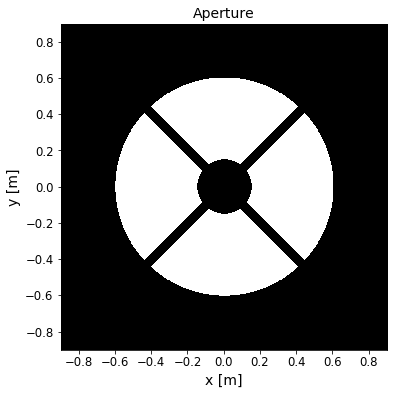

In [8]:
hci.imshow_field(tel_pupil, cmap='gray')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Aperture')

In [9]:
wf = hci.Wavefront(tel_pupil, wvlgth)

## **Zernike**

In [10]:
shift = 0.05                                   # Longitudinal displacement [m]

F_nb = focal_length/diam_aperture
InPhase = 2*np.pi / wvlgth

nwaves = - shift * InPhase / (8*F_nb**2)
print(nwaves)

-121.20342027738401


In [11]:
defocus = hci.zernike(2,0)(pupil_grid)  #evaluate zernike poly on the grid 
defocus /= np.ptp(defocus)               #divise par ptp value
defocus *= nwaves                        # ~ replace old defocus ptp value

wf2 = hci.Wavefront(tel_pupil * np.exp(1j * defocus), wvlgth)

## **Sampling**

To modelise the sampling, the `focal_grid` is used with `sampl_focal` (8 pixels per λ/D)

---
In POPPY, the equivalent is the `osys.add_detector` with a pixel size `pixsize` (0.1 micron)

In [15]:
sampl_focal = 32#8                             #échantillonage q (8 pix per λ/D) 
fov = 8                                     # [λ/D], radius

focal_grid = hci.make_focal_grid(pupil_grid, sampl_focal, fov)

print('Sampling at focal = {} pixels per λ/D'.format(sampl_focal))
print('Field of view = {} λ/D'.format(fov))

Sampling at focal = 2 pixels per λ/D
Field of view = 128 λ/D


In [16]:
pixsize = (wvlgth/(diam_aperture))/(8*10**-6)
print('The size of a pixel is {} micron'.format(pixsize))

The size of a pixel is 0.10416666666666667 micron


## **Propagation**

In [17]:
prop = hci.FraunhoferPropagator(pupil_grid, focal_grid, wvlgth, 10000*focal_length) #10000*
focal_image = prop.forward(wf)
focal_image2 = prop.forward(wf2)              # Defocused !

## **Plots**

In [18]:
print('1 λ/D = {} arcsec'.format(fov*180*3600/np.pi*wvlgth/diam_aperture))

1 λ/D = 22.001579333023614 arcsec


## **PSF of aperture**

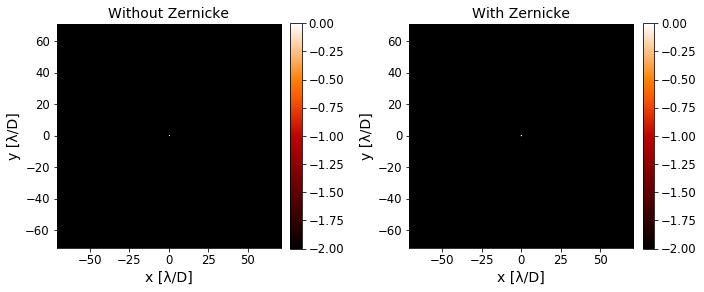

In [19]:
plt.subplot(1, 2, 1)
hci.imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()),cmap='gist_heat' , vmin=-2) #min -4, -3 = plus nice
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('Without Zernicke')

plt.subplot(1, 2, 2)
hci.imshow_field(np.log10(focal_image2.intensity / focal_image2.intensity.max()),cmap='gist_heat' , vmin=-2) #min -4, -3 = plus nice
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('With Zernicke')

plt.tight_layout()
plt.show()

In [ ]:
print("conservation of the intensity ?")
print ("Ratio = {}".format(np.sum(focal_image.intensity)/np.sum(focal_image2.intensity)))

## **PSF in 2D (slice or sum)**

In [ ]:
print(np.sqrt(np.shape(focal_grid)))

In [ ]:
int_map = focal_image.intensity.shaped                         # Take intensity and reshape (1D -> 2D)
int_map2 = focal_image2.intensity.shaped      

xaxis = focal_grid.x.reshape(int_map.shape)[0,:]
xaxis2 = focal_grid.x.reshape(int_map2.shape)[0,:]

psf_slice = int_map[:,int_map.shape[0]//2]     # Cut out the row at 512/2 and normalize
psf_sum = int_map.sum(0)        

psf_slice2 = int_map2[:,int_map2.shape[0]//2]     
psf_sum2 = int_map2.sum(0)  

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)

ax1.plot(xaxis, psf_slice/psf_slice.max(), label='slice')
ax1.plot(xaxis, psf_sum/psf_sum.max(), label='sum')
ax1.set_xlabel('Focal plane distance [$\lambda/D$]')
ax1.set_ylabel('Normalised intensity [I]')
ax1.set_ylim(bottom=10**-2)
ax1.set_xlim(left=-1, right=1)
ax1.set_title('Focused PSF')
ax1.set_yscale('log')
ax1.legend()

plt.tight_layout()
plt.show()

#int_map = focal_image.intensity.shaped                         # Take intensity and reshape (1D -> 2D)
#int_map2 = focal_image2.intensity.shaped      

#xaxis = focal_grid.x.reshape(int_map.shape)[0,:]
#xaxis2 = focal_grid.x.reshape(int_map2.shape)[0,:]

#psf_slice = int_map[:,int_map.shape[0]//2] / int_map.max()     # Cut out the row at 512/2 and normalize
#psf_sum = int_map.sum(0) / int_map.sum(0).max()                

#psf_slice2 = int_map2[:,int_map2.shape[0]//2] / int_map2.max()    
#psf_sum2 = int_map2.sum(0) / int_map2.sum(0).max()                


fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)

ax1.plot(xaxis, psf_slice/psf_slice.max(), label='slice')
ax1.plot(xaxis, psf_sum/psf_sum.max(), label='sum')
ax1.set_xlabel('Focal plane distance [$\lambda/D$]')
ax1.set_ylabel('Normalised intensity [I]')
ax1.set_ylim(bottom=10**-2)
ax1.set_xlim(left=-1, right=1)
ax1.set_title('Focused PSF')
ax1.set_yscale('log')
ax1.legend()

ax2.plot(xaxis2, psf_slice2/psf_slice2.max(), label='slice')
ax2.plot(xaxis2, psf_sum2/psf_sum2.max(), label='sum')
ax2.set_xlabel('Focal plane distance [$\lambda/D$]')
ax2.set_ylabel('Normalised intensity [I]')
ax2.set_ylim(bottom=10**-2)
ax2.set_xlim(left=-1, right=1)
ax2.set_title('Defocused PSF')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)

ax1.plot(focal_grid.x.reshape(int_map.shape)[0,:], psf_slice/psf_slice.max(), label='focused')
ax1.plot(focal_grid.x.reshape(int_map2.shape)[0,:], psf_slice2/psf_slice.max(), label='defocused')
ax1.set_ylim(bottom=10**-2)
ax1.set_xlim(left=-0.5, right=0.5)
ax1.set_xlabel('Focal plane distance [$\lambda/D$]')
ax1.set_ylabel('Normalised intensity [I]')
ax1.set_title('Slice: focused VS defocused')

ax1.set_yscale('log')
ax1.legend()

plt.tight_layout()
plt.show()